In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from pathlib import Path

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

## 9. SketchRNN 데이터셋 다루기

_연습문제: 텐서플로 데이터셋에서 제공하는 SketchRNN 데이터셋으로 분류 모델을 훈련해보세요._

이 데이터셋은 아직 TFDS에서 제공하지 않습니다. 아직 [풀 리퀘스트](https://github.com/tensorflow/datasets/pull/361)가 진행 중입니다. 다행히 이 데이터는 TFRecord로 제공되므로 다운로드해보죠(3,450,000 훈련 스케치와 345,000 테스트 스케치가 포함된 이 데이터셋은 1GB 정도되기 때문에 다운로드 시간이 조금 걸립니다):

In [3]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065312256/1065301781 [==============================] - 141s 0us/step


In [4]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [5]:
train_files

['C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [6]:
eval_files

['C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\NICE\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [7]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [8]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [9]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [10]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [11]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [12]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [13]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.04040405  0.06692913  0.        ]
  [ 0.          0.3070866   0.        ]
  [-0.07575757  0.48425198  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.38271606  0.        ]
  [ 0.05490196  0.44444448  0.        ]
  [ 0.05490196  0.03703701  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.22745097  0.2580645   0.        ]
  [-0.3764706   0.32258064  0.        ]
  [-0.05098039  0.07096773  1.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.          0.26415092  0.        ]
  [ 0.01568628  0.13207549  1.        ]
  [-0.01568628 -0.3773585   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

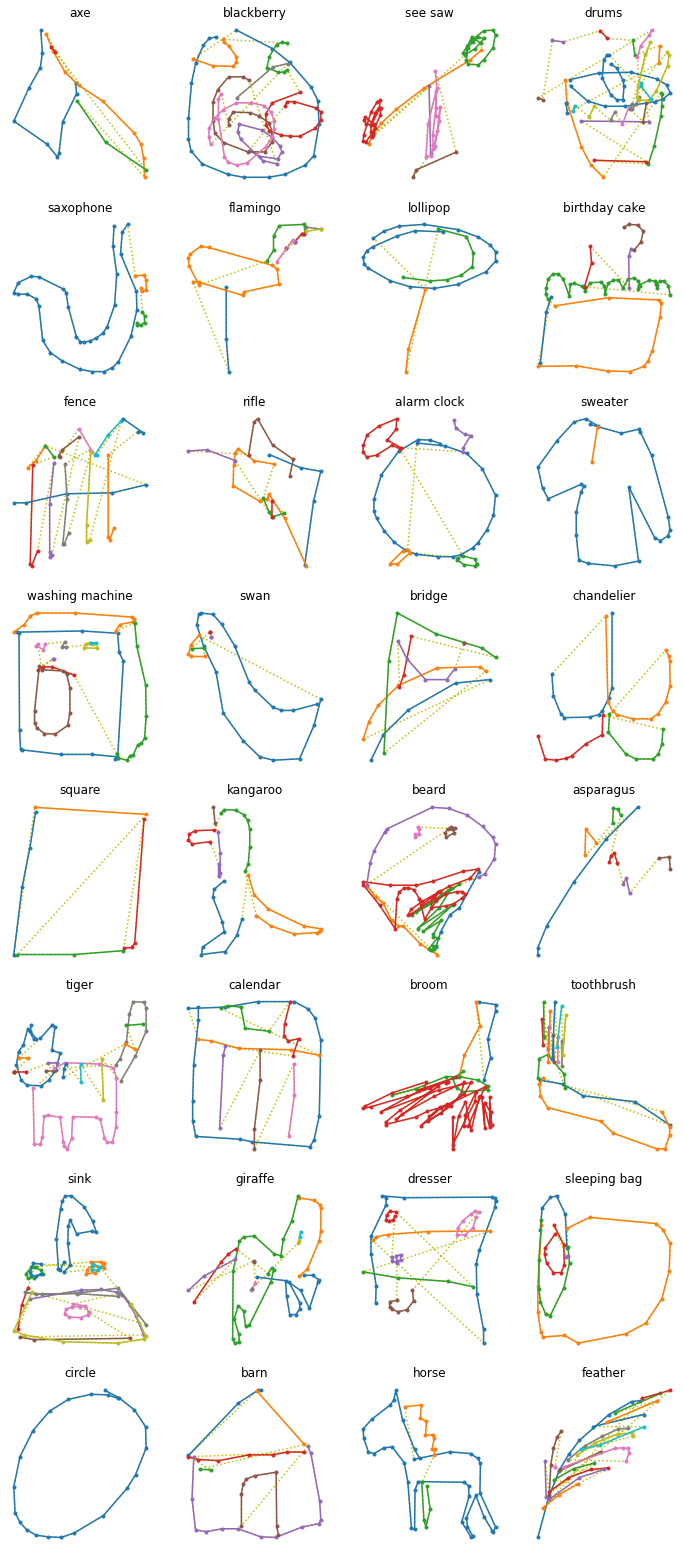

In [14]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

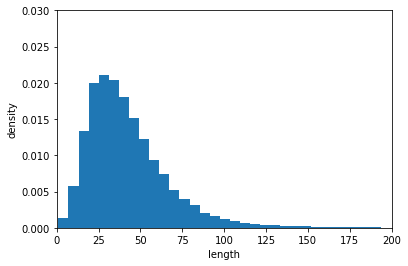

In [15]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [16]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [17]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2609s 24ms/step - loss: 4.1363 - accuracy: 0.1607 - sparse_top_k_categorical_accuracy: 0.3606 - val_loss: 3.3094 - val_accuracy: 0.2640 - val_sparse_top_k_categorical_accuracy: 0.5433
Epoch 2/2
107813/107813 [==============================] - 2630s 24ms/step - loss: 2.7234 - accuracy: 0.3757 - sparse_top_k_categorical_accuracy: 0.6652 - val_loss: 2.4372 - val_accuracy: 0.4307 - val_sparse_top_k_categorical_accuracy: 0.7188


In [18]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [19]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.60625523

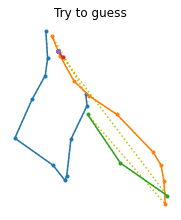

Top-5 predictions:
  1. waterslide 16.466%
  2. pliers 10.560%
  3. knee 6.752%
  4. elbow 6.018%
  5. snowflake 4.611%
Answer: axe


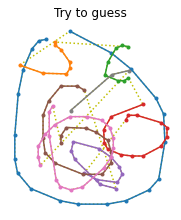

Top-5 predictions:
  1. blackberry 41.024%
  2. soccer ball 20.095%
  3. panda 4.788%
  4. bracelet 3.533%
  5. beard 3.392%
Answer: blackberry


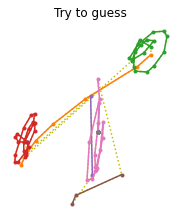

Top-5 predictions:
  1. peas 11.855%
  2. see saw 9.704%
  3. string bean 7.703%
  4. stethoscope 4.494%
  5. marker 3.397%
Answer: see saw


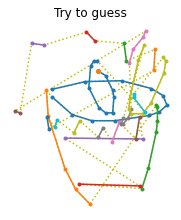

Top-5 predictions:
  1. drums 13.046%
  2. hot tub 7.127%
  3. aircraft carrier 6.390%
  4. bathtub 6.214%
  5. sink 4.460%
Answer: drums


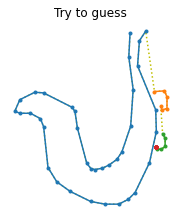

Top-5 predictions:
  1. saxophone 96.194%
  2. snorkel 0.543%
  3. sock 0.368%
  4. stethoscope 0.294%
  5. snake 0.234%
Answer: saxophone


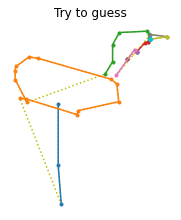

Top-5 predictions:
  1. streetlight 17.747%
  2. mailbox 7.161%
  3. floor lamp 6.165%
  4. flamingo 5.922%
  5. lighthouse 5.325%
Answer: flamingo


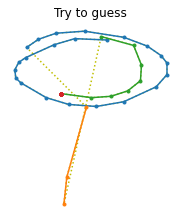

Top-5 predictions:
  1. lollipop 45.206%
  2. ice cream 14.334%
  3. hot air balloon 7.794%
  4. mushroom 6.290%
  5. umbrella 4.882%
Answer: lollipop


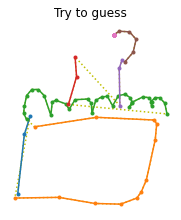

Top-5 predictions:
  1. hot tub 29.909%
  2. birthday cake 20.705%
  3. cake 14.350%
  4. house plant 10.301%
  5. bathtub 3.626%
Answer: birthday cake


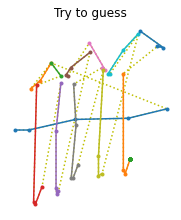

Top-5 predictions:
  1. jacket 12.563%
  2. horse 7.013%
  3. snowflake 5.619%
  4. rifle 5.539%
  5. flashlight 3.709%
Answer: fence


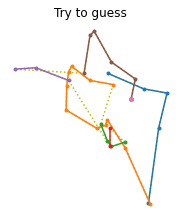

Top-5 predictions:
  1. flashlight 12.958%
  2. lighter 8.888%
  3. syringe 7.681%
  4. drill 6.767%
  5. screwdriver 3.666%
Answer: rifle


In [20]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [21]:
model.save("my_sketchrnn")

INFO:tensorflow:Assets written to: my_sketchrnn\assets


INFO:tensorflow:Assets written to: my_sketchrnn\assets
